#**WHAT ARE THE PARAMETERS CORRELATED WITH HIGH OR LOW ACADEMIC SUCCESS AMONG NEW-YORK HIGHSCHOOL STUDENTS ?**
________

## Exploring the datas

In [35]:
import pandas as pd
import numpy
import re

data_files = [
    "ap_2010.csv",
#    "/content/drive/MyDrive/Dataquest/US_Schools/ap_2010.csv",

   "class_size.csv",
#    "/content/drive/MyDrive/Dataquest/US_Schools/class_size.csv",

   "demographics.csv",
#    "/content/drive/MyDrive/Dataquest/US_Schools/demographics.csv",

   "graduation.csv",
#    "/content/drive/MyDrive/Dataquest/US_Schools/graduation.csv",

   "hs_directory.csv",
#    "/content/drive/MyDrive/Dataquest/US_Schools/hs_directory.csv", 

    "sat_results.csv"
#    "/content/drive/MyDrive/Dataquest/US_Schools/sat_results.csv"
]

data = {}

for f in data_files:
    d = pd.read_csv("/content/drive/MyDrive/Dataquest/US_Schools/{0}".format(f))
    data[f.replace(".csv", "")] = d

## Read the surveys

In [36]:
all_survey = pd.read_csv("/content/drive/MyDrive/Dataquest/US_Schools/survey_all.txt", delimiter="\t", encoding='windows-1252')
d75_survey = pd.read_csv("/content/drive/MyDrive/Dataquest/US_Schools/survey_d75.txt", delimiter="\t", encoding='windows-1252')
survey = pd.concat([all_survey, d75_survey], axis=0)

survey["DBN"] = survey["dbn"]

survey_fields = [
    "DBN", 
    "rr_s", 
    "rr_t", 
    "rr_p", 
    "N_s", 
    "N_t", 
    "N_p", 
    "saf_p_11", 
    "com_p_11", 
    "eng_p_11", 
    "aca_p_11", 
    "saf_t_11", 
    "com_t_11", 
    "eng_t_11", 
    "aca_t_11", 
    "saf_s_11", 
    "com_s_11", 
    "eng_s_11", 
    "aca_s_11", 
    "saf_tot_11", 
    "com_tot_11", 
    "eng_tot_11", 
    "aca_tot_11",
]
survey = survey.loc[:,survey_fields]
data["survey"] = survey

# Add DBN columns to identify unique highschools

In [39]:
data["hs_directory"]["DBN"] = data["hs_directory"]["dbn"]

def pad_csd(num):
    string_representation = str(num)
    if len(string_representation) > 1:
        return string_representation
    else:
        return "0" + string_representation
    
data["class_size"]["padded_csd"] = data["class_size"]["CSD"].apply(pad_csd)
data["class_size"]["DBN"] = data["class_size"]["padded_csd"] + data["class_size"]["SCHOOL CODE"]

# Convert columns to numeric

In [40]:
cols = ['SAT Math Avg. Score', 'SAT Critical Reading Avg. Score', 'SAT Writing Avg. Score']
for c in cols:
    data["sat_results"][c] = pd.to_numeric(data["sat_results"][c], errors="coerce")

data['sat_results']['sat_score'] = data['sat_results'][cols[0]] + data['sat_results'][cols[1]] + data['sat_results'][cols[2]]

def find_lat(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lat = coords[0].split(",")[0].replace("(", "")
    return lat

def find_lon(loc):
    coords = re.findall("\(.+, .+\)", loc)
    lon = coords[0].split(",")[1].replace(")", "").strip()
    return lon

data["hs_directory"]["lat"] = data["hs_directory"]["Location 1"].apply(find_lat)
data["hs_directory"]["lon"] = data["hs_directory"]["Location 1"].apply(find_lon)

data["hs_directory"]["lat"] = pd.to_numeric(data["hs_directory"]["lat"], errors="coerce")
data["hs_directory"]["lon"] = pd.to_numeric(data["hs_directory"]["lon"], errors="coerce")

# Condense datasets

In [41]:
class_size = data["class_size"]
class_size = class_size[class_size["GRADE "] == "09-12"]
class_size = class_size[class_size["PROGRAM TYPE"] == "GEN ED"]

class_size = class_size.groupby("DBN").agg(numpy.mean)
class_size.reset_index(inplace=True)
data["class_size"] = class_size

data["demographics"] = data["demographics"][data["demographics"]["schoolyear"] == 20112012]

data["graduation"] = data["graduation"][data["graduation"]["Cohort"] == "2006"]
data["graduation"] = data["graduation"][data["graduation"]["Demographic"] == "Total Cohort"]

# Convert AP scores to numeric

In [42]:
cols = ['AP Test Takers ', 'Total Exams Taken', 'Number of Exams with scores 3 4 or 5']

for col in cols:
    data["ap_2010"][col] = pd.to_numeric(data["ap_2010"][col], errors="coerce")

# Combine the datasets

In [43]:
combined = data["sat_results"]

combined = combined.merge(data["ap_2010"], on="DBN", how="left")
combined = combined.merge(data["graduation"], on="DBN", how="left")

to_merge = ["class_size", "demographics", "survey", "hs_directory"]

for m in to_merge:
    combined = combined.merge(data[m], on="DBN", how="inner")

combined = combined.fillna(combined.mean())
combined = combined.fillna(0)

# Add a school district column for mapping

In [44]:
def get_first_two_chars(dbn):
    return dbn[0:2]

combined["school_dist"] = combined["DBN"].apply(get_first_two_chars)

# Find correlations

In [45]:
correlations = combined.corr()
correlations = correlations["sat_score"]
print(correlations)

SAT Critical Reading Avg. Score    0.986820
SAT Math Avg. Score                0.972643
SAT Writing Avg. Score             0.987771
sat_score                          1.000000
AP Test Takers                     0.523140
                                     ...   
priority08                              NaN
priority09                              NaN
priority10                              NaN
lat                               -0.121029
lon                               -0.132222
Name: sat_score, Length: 67, dtype: float64


# Plotting survey correlations

In [46]:
# Remove DBN since it's a unique identifier, not a useful numerical value for correlation.
survey_fields.remove("DBN")

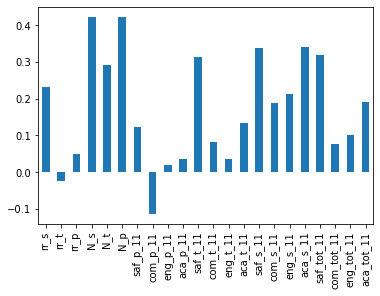

In [47]:
%matplotlib inline
combined.corr()["sat_score"][survey_fields].plot.bar()

### Some of the most correlated answer regarding the SAT scores are : 
- rr_s, the student response rate
- saf_t_11 and saf_s_11, the perception of safety among students and teachers


And it makes sense, given that a respondant is more likely to be involved in his academic path than a non respondant, and that a good perceived safety appears to be relevant for a good learning environnement.

## About the safety score

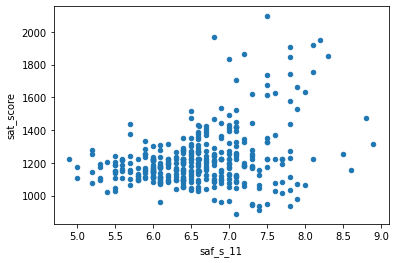

In [48]:
combined.plot.scatter("saf_s_11", "sat_score")

### There is a correlation between safety and SAT score. For example, not a single school with a safety score under 6.7 succeed to get a mean SAT score above 1600. 

## Best areas to study in New-York

In [51]:
boros = combined.groupby("boro").agg(numpy.mean)["saf_s_11"]
print(boros)

boro
Bronx            6.606577
Brooklyn         6.370755
Manhattan        6.831370
Queens           6.721875
Staten Island    6.530000
Name: saf_s_11, dtype: float64


### Manatthan and Queens are on top regarding SAT results, while Brooklyn get the lowest mean score.

## Gender differences 

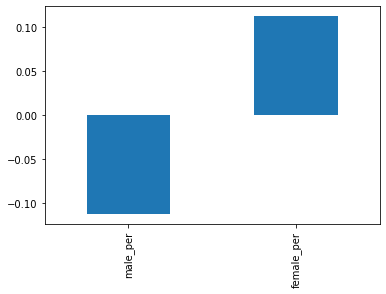

In [52]:
gender_fields = ["male_per", "female_per"]
combined.corr()["sat_score"][gender_fields].plot.bar()


### A greater percentage of female in a given school is slightly correlated with higher score in SAT.

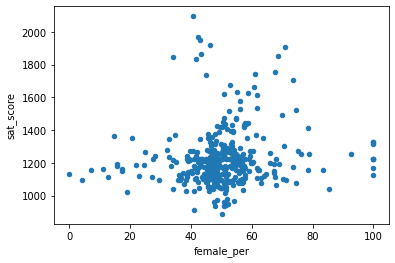

In [53]:
combined.plot.scatter("female_per", "sat_score")

### But the SAT score isn't correlated by the womens headcount in itself 
### The difference seems to be related to several highschools with great SAT results, who may tend to select more female than male candidate. Let's verify which one. 

In [54]:
print(combined[(combined["female_per"] > 60) & (combined["sat_score"] > 1700)]["SCHOOL NAME"])

5                         BARD HIGH SCHOOL EARLY COLLEGE
26                         ELEANOR ROOSEVELT HIGH SCHOOL
60                                    BEACON HIGH SCHOOL
61     FIORELLO H. LAGUARDIA HIGH SCHOOL OF MUSIC & A...
302                          TOWNSEND HARRIS HIGH SCHOOL
Name: SCHOOL NAME, dtype: object


### According to wikipedia these schools are very selective Arts Schools, a field in which traditionnaly, educational facilities receive more female appliance (in proportion)

## CONCLUSION
____________
### **Among other factors (such as academic standards of a given highschool) the perceived safety seems to be the most relevant of all to anticipate mean SAT scores, whether it is a judgment coming from students or from teachers.**   